In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np
import scipy as sp
import pandas as pd
import datetime
import mysql.connector
import os
import pytz
import simplejson as json
import seaborn as sns
# %matplotlib inline
import matplotlib.pyplot as plt

### Make the model to predict bike availability for the web

In [2]:
#### Gather historical data from the database so we don't have to make a bajillion calls while evaluating the model
## Get mysql credentials
mysql_host = os.getenv('JAWSDB_HOST')
mysql_username = os.getenv('JAWSDB_USERNAME')
mysql_password = os.getenv('JAWSDB_PASSWORD')
mysql_database = os.getenv('JAWSDB_DATABASE')

## Open database connection
mysqldb = mysql.connector.connect(host=mysql_host, user=mysql_username, passwd=mysql_password, db=mysql_database)
cur = mysqldb.cursor()

## Get station names
stations = []
cur.execute("SELECT `COLUMN_NAME` FROM `INFORMATION_SCHEMA`.`COLUMNS` WHERE `TABLE_SCHEMA`='"+str(mysql_database)+"' AND `TABLE_NAME`='station_availability';")
for entry in cur.fetchall():
    try:
        stations.append(int(entry[0]))
    except:
        continue

## Get timepoints and number of bikes at each station
cur.execute("SELECT * FROM station_availability;")
timepoints = []
values = []
for each in cur.fetchall():
    timepoints.append(each[0])
    values.append(each[1:])

## Create historical dataframe
df = pd.DataFrame(values, index = timepoints, columns = stations)
df.index = pd.to_datetime(df.index)
df.head()

,31000,31001,31002,31003,31004,31005,31006,31007,31008,31009,...,32217,32218,32219,32220,32221,32222,32223,32224,32225,31924
2017-06-11 16:50:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:00:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:10:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:20:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:30:00,1,3,11,9,9,14,0,7,3,3,...,5,6,7,4,8,7,5,6,8,NaN


In [3]:
#### Now let's set up our evaluation metric
#### Since we care more about whether or not a user will be able to get a bike rather than how many bikes/docks are at each station this is really a binary classification problem.
#### The classes will be determined by a cutoff of 2 bikes/docks or more representing a "yes."
#### After our tests of various different models we saw that a simple linear regression that predicts the number of bikes performs similar to more advanced models in terms of R^2 and RMSE.
#### For speed's sake (since this is a webapp) we will use this linear regression and convert the prediction to a "yes" or "no" based on the cutoff value.
#### Our evaluation metric will thus just be classification accuracy since the problem is such a simple one.
def eval_metric(preds, actual_values, cutoff):
    scores = []
    for i in range(len(preds)):
        if (preds[i] >= cutoff and actual_values[i] >= cutoff) or (preds[i] < cutoff and actual_values[i] < cutoff):
            scores.append(1)
        else:
            scores.append(0)
    return float(scores.count(1))/len(scores)

### Get stats for predictions across stations and time delays

In [24]:
def makePrediction(time_to_predict, station, time_difference):
    ## Convert time_to_predict into datetime
    datetime_to_predict = pd.to_datetime(time_to_predict)

    ## Get data for training the model
    ## Make date range to get values for the day a week prior to the query
    ############## USE THIS FOR TESTING UNTIL ENOUGH DATA ARE ACQUIRED, THEN CHANGE FROM 1 DAY TO 7 DAYS PRIOR ####################
    start_time = datetime_to_predict - datetime.timedelta(hours = 24)
    end_time = datetime_to_predict

    ## Make container for data
    train_Xs = []
    train_ys = []
    ## Get data from the dataframe for a station between two times passed in as datetime objects.
    temp_df = pd.DataFrame(df[start_time:end_time][station])
    temp_df.columns = ['y']
            
    ## Make lag features
    number_of_lags = 6
    ## Add lags
    for i in range(1,number_of_lags+1):
        temp_df['lag_'+str(10*i+time_difference)] = temp_df.y.shift(int(i+time_difference/10))
    ## Drop NAs
    temp_df.dropna(inplace = True, axis = 0)
    ## Return X and y values
    temp_Xs = temp_df.drop('y', axis = 1)
    temp_ys = temp_df.y

    ## Get data for making the prediction
    train_Xs = temp_Xs.iloc[:-1, :]
    train_ys = temp_ys.iloc[:-1]
    test_Xs = temp_Xs.iloc[-1, :]
    test_y = temp_ys.iloc[-1]
    
    features = train_Xs.columns
    
    ## Make a linear regression and train it on the previous day
    lr = LinearRegression()
    lr.fit(train_Xs, train_ys)
    ## Make a prediction for the time in question
    prediction = int(np.round(lr.predict(np.array(test_Xs).reshape(1,-1))))
    ## return the prediction and the actual value
    return prediction, test_y, lr, features

def makePlot(preds, actual_vals, coefs_list, feature_names, station, time_diff):
    ## Convert the list of arrays each with a single value to a list of values
    lr_variance = r2_score(actual_vals, preds)
    lr_rmse = np.sqrt(mean_squared_error(actual_vals, preds))
    lr_r = sp.stats.pearsonr(actual_vals, preds)[0]

    sns.set(font_scale = 2)
    fig = plt.figure(figsize = [18, 7])
    plt.subplot(1,3,1)
    plt.scatter(actual_vals, preds)
    plt.title('Predictions vs actual values')
    plt.ylabel('Predicted number of rides')
    plt.xlabel('Actual number of rides')
    plt.annotate('r = '+str(sp.stats.pearsonr(actual_vals, preds)[0])+"\nR^2 = "+str(lr_variance)+"\nRMSE = "+str(lr_rmse), xy=(0.01, 0.82), xycoords='axes fraction', size = 20)
    plt.tight_layout()
    plt.subplot(1,3,2)
    plt.plot(actual_vals)
    plt.plot(preds)
    plt.title('Bike availability over time')
    plt.xlabel('Time point index')
    plt.ylabel('Number of bikes\n(green = predicted)')
    plt.annotate('% accuracy = '+str(eval_metric(actual_vals, preds,2)), xy=(0.01, 0.94), xycoords='axes fraction', size = 20)
    plt.annotate('time difference = '+str(time_diff), xy=(0.01, 0.88), xycoords='axes fraction', size = 20)
    plt.subplot(1,3,3)
    coefs = pd.DataFrame([(x,y) for (y,x) in sorted(list(zip(np.abs(np.mean(np.array(coefs_list), axis = 0)), feature_names))[:], reverse = True)], 
                         columns = ['Feature', 'Importance (magnitude of coefficient)'])
    sns.barplot(x = 'Feature', y = 'Importance (magnitude of coefficient)', data = coefs)
    plt.xticks(rotation=90)
    plt.title('Average feature importance')
    plt.ylabel('Importance (magnitude of coefficient)')
    plt.tight_layout()
    plt.savefig('../figures/station_models/'+str(station)+'-'+str(time_diff)+'min.png', dpi = 300)

## Give a start time for predictions
start_time_to_predict = '2017-06-12 17:00'
## Give an end time for predictions
end_time_to_predict = '2017-06-14 17:00'
## Make a date range of dates to predict
date_range = pd.date_range(start = pd.to_datetime(start_time_to_predict), end = pd.to_datetime(end_time_to_predict), freq = '10min')
## Make a list of stations for which to make predictions (or just predict all in stations from before)
# stations_to_predict = [31623, 31304, 31520, 31242, 31207, 31204, 31635, 31019, 31919, 31047, 31004]
# stations_to_predict = [31623]
stations_to_predict = stations
## Make various time diffs
time_diffs = [10*i for i in range(1,7)]

evaluation = {}
## Make a prediction for various stations
init_time = datetime.datetime.now()
for i, prediction_station in enumerate(stations_to_predict):
    temp_dict = {}
    ## Make a prediction for a range of time diffs
    for prediction_time_diff in time_diffs:
        ## Make containers for relevant values for evaluation
        predictions = []
        test_ys = []
        coefs_list = []
        ## Make a prediction for each time in the date range
        for prediction_time in date_range:
            pred, actual_value, lr, features = makePrediction(prediction_time, prediction_station, prediction_time_diff)
            predictions.append(pred)
            test_ys.append(actual_value)
            coefs_list.append(lr.coef_)
            ## Add evaluations to dict of difference time diffs
        temp_dict[prediction_time_diff] = eval_metric(test_ys, predictions, 2)
        makePlot(predictions, test_ys, coefs_list, features, prediction_station, prediction_time_diff)
    evaluation[prediction_station] = temp_dict
    print('Done with station', i+1, 'of', len(stations_to_predict), '-', datetime.datetime.now() - init_time, 'since start.')

Done with station 1 of 469 - 0:00:07.807966 since start.
Done with station 2 of 469 - 0:00:16.168600 since start.
Done with station 3 of 469 - 0:00:24.431725 since start.
Done with station 4 of 469 - 0:00:33.145416 since start.
Done with station 5 of 469 - 0:00:41.576046 since start.
Done with station 6 of 469 - 0:00:49.352728 since start.
Done with station 7 of 469 - 0:00:57.038967 since start.
Done with station 8 of 469 - 0:01:04.722449 since start.
Done with station 9 of 469 - 0:01:13.295290 since start.
Done with station 10 of 469 - 0:01:22.538064 since start.
Done with station 11 of 469 - 0:01:31.287404 since start.
Done with station 12 of 469 - 0:01:39.001437 since start.
Done with station 13 of 469 - 0:01:47.457799 since start.
Done with station 14 of 469 - 0:01:56.184408 since start.
Done with station 15 of 469 - 0:02:06.119986 since start.
Done with station 16 of 469 - 0:02:13.977875 since start.
Done with station 17 of 469 - 0:02:22.262106 since start.
Done with station 18 of

Done with station 142 of 469 - 0:21:11.894245 since start.
Done with station 143 of 469 - 0:21:21.281143 since start.
Done with station 144 of 469 - 0:21:30.904524 since start.
Done with station 145 of 469 - 0:21:40.347667 since start.
Done with station 146 of 469 - 0:21:49.701423 since start.
Done with station 147 of 469 - 0:21:59.135957 since start.
Done with station 148 of 469 - 0:22:07.978451 since start.
Done with station 149 of 469 - 0:22:16.419632 since start.
Done with station 150 of 469 - 0:22:24.857425 since start.
Done with station 151 of 469 - 0:22:33.431828 since start.
Done with station 152 of 469 - 0:22:41.881595 since start.
Done with station 153 of 469 - 0:22:50.119146 since start.
Done with station 154 of 469 - 0:22:58.461297 since start.
Done with station 155 of 469 - 0:23:06.886936 since start.
Done with station 156 of 469 - 0:23:15.708275 since start.
Done with station 157 of 469 - 0:23:24.719104 since start.
Done with station 158 of 469 - 0:23:33.382162 since star

Done with station 281 of 469 - 0:42:34.335227 since start.
Done with station 282 of 469 - 0:42:43.619621 since start.
Done with station 283 of 469 - 0:42:52.354117 since start.
Done with station 284 of 469 - 0:43:01.689840 since start.
Done with station 285 of 469 - 0:43:11.029327 since start.
Done with station 286 of 469 - 0:43:19.699249 since start.
Done with station 287 of 469 - 0:43:28.892853 since start.
Done with station 288 of 469 - 0:43:37.642201 since start.
Done with station 289 of 469 - 0:43:47.258763 since start.
Done with station 290 of 469 - 0:43:56.266771 since start.
Done with station 291 of 469 - 0:44:04.672520 since start.
Done with station 292 of 469 - 0:44:13.833006 since start.
Done with station 293 of 469 - 0:44:22.561874 since start.
Done with station 294 of 469 - 0:44:31.489610 since start.
Done with station 295 of 469 - 0:44:40.911458 since start.
Done with station 296 of 469 - 0:44:50.177328 since start.
Done with station 297 of 469 - 0:44:59.013715 since star

Done with station 420 of 469 - 1:03:46.015689 since start.
Done with station 421 of 469 - 1:03:55.678684 since start.
Done with station 422 of 469 - 1:04:05.091149 since start.
Done with station 423 of 469 - 1:04:14.406004 since start.
Done with station 424 of 469 - 1:04:23.775658 since start.
Done with station 425 of 469 - 1:04:33.358578 since start.
Done with station 426 of 469 - 1:04:43.038492 since start.
Done with station 427 of 469 - 1:04:52.721851 since start.
Done with station 428 of 469 - 1:05:03.214224 since start.
Done with station 429 of 469 - 1:05:12.525666 since start.
Done with station 430 of 469 - 1:05:21.083856 since start.
Done with station 431 of 469 - 1:05:29.628525 since start.
Done with station 432 of 469 - 1:05:38.188120 since start.
Done with station 433 of 469 - 1:05:46.606460 since start.
Done with station 434 of 469 - 1:05:55.240627 since start.
Done with station 435 of 469 - 1:06:04.496931 since start.
Done with station 436 of 469 - 1:06:13.886874 since star

IndexError: single positional indexer is out-of-bounds

In [27]:
## Let's look at some stats of the scores
eval_df = pd.DataFrame(evaluation)
eval_df.to_csv('../data/single_model_evaluation_data.csv')
eval_df

,31000,31001,31002,31003,31004,31005,31006,31007,31008,31009,...,32216,32217,32218,32219,32220,32221,32222,32223,32224,32225
10,1.0,1.0,1.0,0.982699,0.986159,0.993080,1.0,0.972318,0.965398,1.0,...,1.0,0.986159,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20,1.0,1.0,1.0,0.979239,0.972318,0.986159,1.0,0.965398,0.937716,1.0,...,1.0,0.979239,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30,1.0,1.0,1.0,0.979239,0.965398,0.986159,1.0,0.961938,0.910035,1.0,...,1.0,0.972318,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
40,1.0,1.0,1.0,0.979239,0.958478,0.982699,1.0,0.958478,0.885813,1.0,...,1.0,0.965398,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50,1.0,1.0,1.0,0.975779,0.951557,0.982699,1.0,0.958478,0.878893,1.0,...,1.0,0.958478,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60,1.0,1.0,1.0,0.968858,0.944637,0.982699,1.0,0.955017,0.878893,1.0,...,1.0,0.951557,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
eval_df = pd.read_csv('../data/single_model_evaluation_data.csv', index_col = 0)
eval_df

,31000,31001,31002,31003,31004,31005,31006,31007,31008,31009,...,32216,32217,32218,32219,32220,32221,32222,32223,32224,32225
10,1.0,1.0,1.0,0.982699,0.986159,0.993080,1.0,0.972318,0.965398,1.0,...,1.0,0.986159,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20,1.0,1.0,1.0,0.979239,0.972318,0.986159,1.0,0.965398,0.937716,1.0,...,1.0,0.979239,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
30,1.0,1.0,1.0,0.979239,0.965398,0.986159,1.0,0.961938,0.910035,1.0,...,1.0,0.972318,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
40,1.0,1.0,1.0,0.979239,0.958478,0.982699,1.0,0.958478,0.885813,1.0,...,1.0,0.965398,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50,1.0,1.0,1.0,0.975779,0.951557,0.982699,1.0,0.958478,0.878893,1.0,...,1.0,0.958478,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60,1.0,1.0,1.0,0.968858,0.944637,0.982699,1.0,0.955017,0.878893,1.0,...,1.0,0.951557,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### The model makes very similar classification predictions across time differences

0.015114834311596003


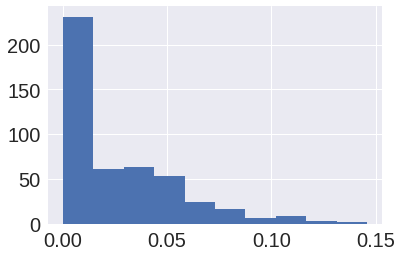

In [37]:
## standard deviation across time differences is small
print(eval_df.std().median())
eval_df.std().hist()

### The model's accuracy varies between stations but on average is high

Median accuracy = 0.9411764705882353
Minimum accuracy = 0.491349480969


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5c8ba98d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff5c9cd7358>]], dtype=object)

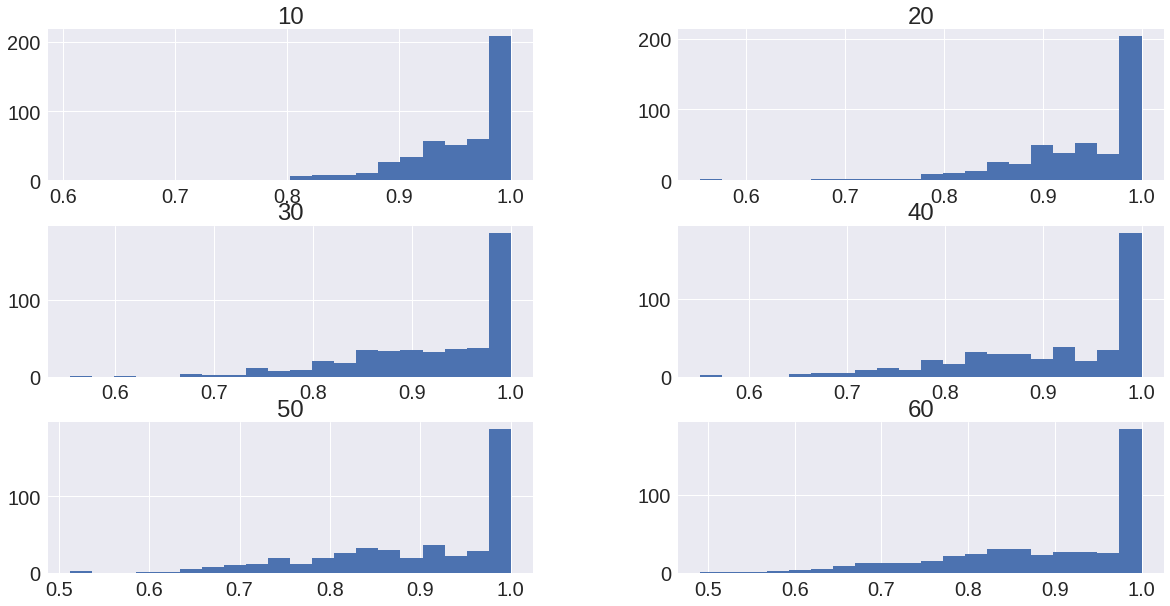

In [29]:
## Average score
print('Median accuracy =', eval_df.median().median())
print('Minimum accuracy =', eval_df.min().min())
## Distribution of scores for 0 time differences
%matplotlib inline
eval_df.T.hist(bins = 20, figsize = [20, 10])

In [7]:
## Since the model is generally pretty good we'll use this iteration for the webapp